In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

import pickle
import json
import sys
import numpy.random as random
sys.path.append("../../")

import time 

from src.online_prediction.OnlineDataProcessor.dataProcessor import DataProcessor
from src.context_aware.models import createModel
from src.context_aware.config.configs import DataProcessorConfig, ModelConfig

In [2]:
direction = "forward"
window_length = 20

In [3]:
from pathlib import Path

# Use absolute path for reliability in Jupyter notebooks
project_root = Path(r"c:\Users\Ye\Documents\YuYeh_Documents\L2S\Projects\context_aware_traffic_predictor")
csv_path = project_root / "data" / "processed" / "dpdr" / f"combined_{direction}.csv"

csv_data = pd.read_csv(csv_path)
print(csv_data.head(5))

     Time  Transmition Flags         0         1         2         3  \
0  0.0000                1.0  0.243081  0.989688 -0.168696  0.259059   
1  0.0133                0.0  0.243081  0.989688 -0.168696  0.259059   
2  0.0267                0.0  0.243081  0.989688 -0.168696  0.259059   
3  0.0277                0.0  0.243081  0.989688 -0.168696  0.259059   
4  0.0410                0.0  0.243081  0.989688 -0.168696  0.259059   

          4         5         6         7         8         9        10  \
0  0.988845 -0.281148  0.205538  0.968163 -0.270712  0.150633  1.050514   
1  0.988845 -0.281148  0.205538  0.968163 -0.270712  0.150633  1.050514   
2  0.988845 -0.281148  0.205538  0.968163 -0.270712  0.150633  1.050514   
3  0.988845 -0.281148  0.205538  0.968163 -0.270712  0.150633  1.050514   
4  0.988845 -0.281148  0.205538  0.968163 -0.270712  0.150633  1.050514   

         11  
0 -0.211362  
1 -0.211362  
2 -0.211362  
3 -0.211362  
4 -0.211362  


In [4]:
model_folder = "../../data/models/context_aware"

with open(f"{model_folder}/direction_{direction}_lenWindow_{window_length}_modelConfig.pkl", "rb") as f:
    modelConfig = pickle.load(f)

model, device = createModel(modelConfig)
model.load_checkpoint(f"{model_folder}/direction_{direction}_lenWindow_{window_length}.pth")

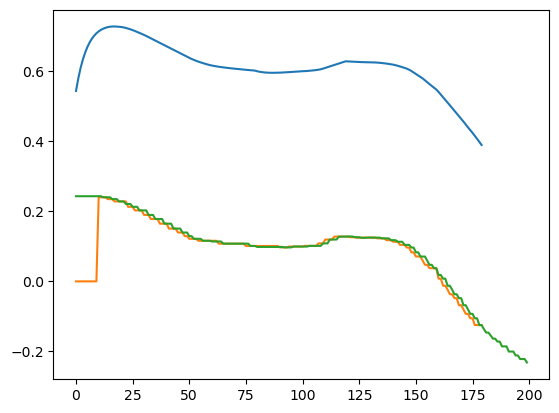

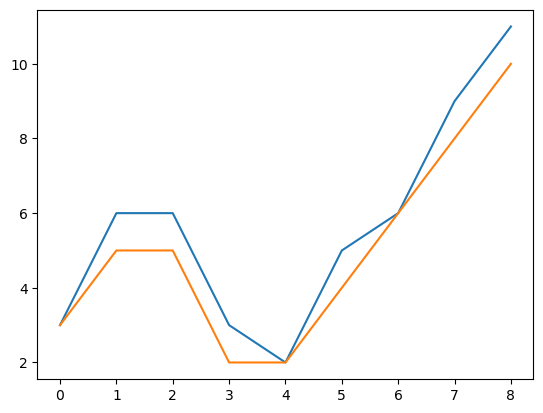

In [5]:
dataProcesorConfig = DataProcessorConfig.initialize(dim_data=12, window_length=window_length)
dataProcesor = DataProcessor(dataProcesorConfig)

last_time = time.time()

context_list = []
context_filtered_list = []
context_no_smooth_list = []
traffic_list = []
traffic_gt_list = []
transmission_list = []
count = 1
N_count = 200
while True:
    if time.time() - last_time > dataProcesorConfig.Ts:
        transmission = csv_data.iloc[count, 1]
        data_point = csv_data.iloc[count, 2:].values
      
        if int(transmission) == 1:
            dataProcesor.add_data_point(data_point)
        last_time = time.time()

        transmission_list.append(transmission)
        if count % dataProcesorConfig.window_length == 0:
            context, last_trans_sources, context_no_smooth, debugs = dataProcesor.get_window_features()
            (flags, timestamps_bin) = debugs
            context_list.append(context)
            context_no_smooth_list.append(context_no_smooth)
            traffic_list.append(np.sum(flags))
            traffic_gt_list.append(np.sum(transmission_list[-dataProcesorConfig.window_length:]))
        count += 1
    
    if count >= N_count:
        break

dim_data = 12
context_list = np.array(context_list).reshape(-1, dim_data)
context_no_smooth_list = np.array(context_no_smooth_list).reshape(-1, dim_data)
traffic_list = np.array(traffic_list).reshape(-1)

plt.plot(context_list[: , 0])
plt.plot(context_no_smooth_list[:, 0])
plt.plot(csv_data.iloc[:N_count, 2].values)
plt.show()

plt.plot(traffic_gt_list)
plt.plot(traffic_list)
plt.show()